# SD-TSIA204: computer lab 1

*Louis Personnaz*

## Imports

In [3]:
import scipy

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Question 1

In [4]:
filename = "invest.txt"

In [9]:
df = pd.read_csv(filename)

In [10]:
df.head()

,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


In [11]:
n = df.shape[0]

## Question 2

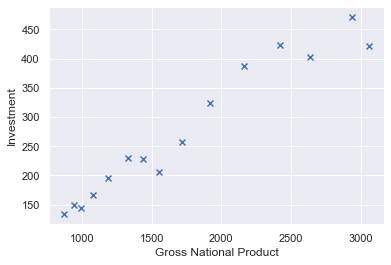

In [12]:
plt.scatter(df["gnp"], df["invest"], marker='x')
plt.xlabel("Gross National Product")
plt.ylabel("Investment")
plt.show()

In [13]:
df["gnp"] = np.log10(df["gnp"])
df["invest"] = np.log10(df["invest"])

## Question 3

In [14]:
norm22 = lambda x: np.linalg.norm(x, 2)**2

In [15]:
def beta_hat(x, y):
    xm, ym = np.mean(x), np.mean(y)
    xc, yc = x - xm, y - ym
    beta_hat1 = np.dot(xc, yc) / norm22(xc)
    beta_hat0 = ym - beta_hat1 * xm
    return (beta_hat0, beta_hat1)

In [16]:
beta_hat0, beta_hat1 = beta_hat(df["gnp"], df["invest"])
print(f"est. intercept = {beta_hat0}\nest. slope = {beta_hat1}")

est. intercept = -0.8527768816035062
est. slope = 1.015281401598871


In [17]:
def sigma_hat2(x, y):
    beta_hat0, beta_hat1 = beta_hat(x, y)
    return norm22(y - beta_hat1 * x - beta_hat0) / (x.size-2)

In [18]:
sigma2 = sigma_hat2(df["gnp"], df["invest"])
print(f"est. variance = {sigma2}")

est. variance = 0.0014478472417810714


In [19]:
def r2(x, y):
    beta_hat0, beta_hat1 = beta_hat(x, y)
    return np.corrcoef(y, beta_hat0 + beta_hat1 * x)[0][1]**2 # select a non-diagonal coeff in the symmetric 2x2 matrix

In [20]:
rsquared = r2(df["gnp"], df["invest"])
print(f"determination coefficient: r^2 = {rsquared}")

determination coefficient: r^2 = 0.9627572956057859


It's not that good...

## Question 4

In [21]:
def root_var_beta_hat1(x, y):
    return np.sqrt(sigma_hat2(x, y) / norm22(x - np.mean(x)))

In [22]:
alpha = 0.001
statistic = beta_hat1 / root_var_beta_hat1(df["gnp"], df["invest"])
quantile = scipy.stats.t.ppf(1-alpha/2, n-2)
print(f"value of the statistic = {statistic}\nstatistic in interval? {(statistic > -quantile) & (statistic < quantile)}")

value of the statistic = 18.33198445686665
statistic in interval? False


We can reject the null hypothesis, i.e. the slope is zero, with a confidence level of 99.9%.

In [25]:
print(f"the p-value is {scipy.stats.t.sf(statistic, n-2)}")

the p-value is 5.681857666778573e-11


## Question 5

In [26]:
gnp = np.log10(1000)
invest = beta_hat0 + beta_hat1 * gnp
print(f"estimated investment = {10**invest:.5g}")

estimated investment = 155.98


In [27]:
def CI(x, y, x0, alpha):
    beta_hat0, beta_hat1 = beta_hat(x, y)
    quantile = scipy.stats.t.ppf(1-alpha/2, n-2)
    sigma2 = sigma_hat2(x, y)
    root = np.sqrt(1/n + (x0-np.mean(x))**2/norm22(x - np.mean(x)))
    return (beta_hat0+beta_hat1*x0-quantile*sigma2*root, beta_hat0+beta_hat1*x0+quantile*sigma2*root)

In [28]:
def PI(x, y, x0, alpha):
    beta_hat0, beta_hat1 = beta_hat(x, y)
    quantile = scipy.stats.t.ppf(1-alpha/2, n-2)
    sigma2 = sigma_hat2(x, y)
    root = np.sqrt(1 + 1/n + (x0-np.mean(x))**2/norm22(x - np.mean(x)))
    return (beta_hat0+beta_hat1*x0-quantile*sigma2*root, beta_hat0+beta_hat1*x0+quantile*sigma2*root)

In [29]:
alpha = 0.1
CIl, CIr = CI(df["gnp"], df["invest"], gnp, alpha)
PIl, PIr = PI(df["gnp"], df["invest"], gnp, alpha)

In [31]:
print(f"For a GNP of {10**gnp}, necessary investment at the level {100*(1-alpha)}%:\nCI = [{10**CIl:.5g}, {10**CIr:.5g}]\nPI = [{10**PIl:.5g}, {10**PIr:.5g}]")

For a GNP of 1000.0, necessary investment at the level 90.0%:
CI = [155.61, 156.34]
PI = [154.99, 156.97]


## Question 6

In [32]:
# just for some nice colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

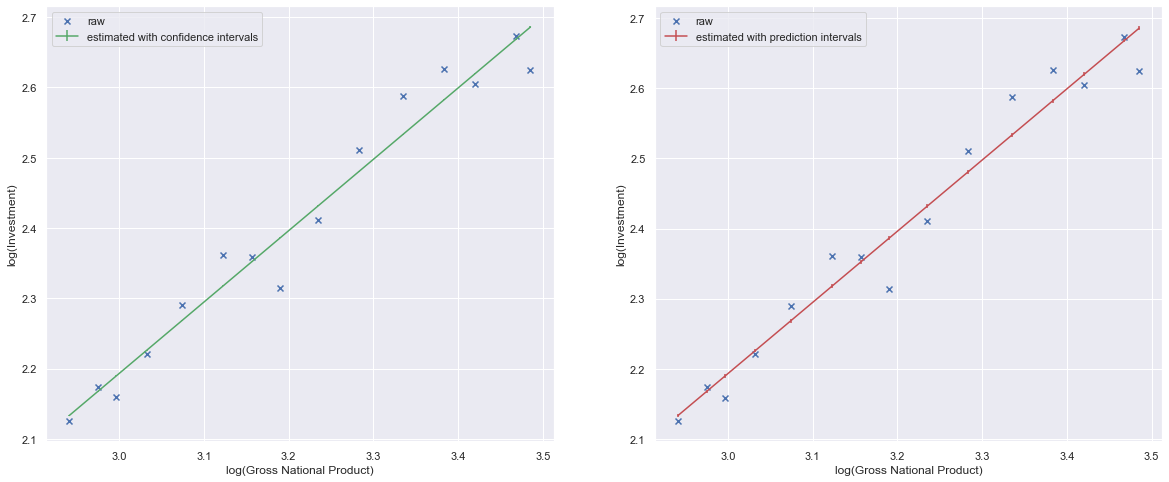

In [33]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

ax0.scatter(df["gnp"], df["invest"], label="raw", marker='x')
CIerr = CI(df["gnp"], df["invest"], df["gnp"], alpha)[0] - (beta_hat0 + beta_hat1 * df["gnp"])
ax0.errorbar(df["gnp"], beta_hat0 + beta_hat1 * df["gnp"], yerr=CIerr, label="estimated with confidence intervals", c=colors[2])
ax0.set_xlabel("log(Gross National Product)")
ax0.set_ylabel("log(Investment)")
ax0.legend()

ax1.scatter(df["gnp"], df["invest"], label="raw", marker='x')
PIerr = PI(df["gnp"], df["invest"], df["gnp"], alpha)[0] - (beta_hat0 + beta_hat1 * df["gnp"])
ax1.errorbar(df["gnp"], beta_hat0 + beta_hat1 * df["gnp"], yerr=PIerr, label="estimated with prediction intervals", c=colors[3])
ax1.set_xlabel("log(Gross National Product)")
ax1.set_ylabel("log(Investment)")
ax1.legend()

plt.show()

## Question 7

In [34]:
model = LinearRegression()
model.fit(df["gnp"].values.reshape(-1, 1), df["invest"])
sk_beta_hat0, sk_beta_hat1 = model.intercept_, model.coef_[0]
sk_rsquared = r2_score(df["invest"], sk_beta_hat0 + sk_beta_hat1*df["gnp"])

In [35]:
print(f"sk intercept = {sk_beta_hat0}\nsk slope = {sk_beta_hat1}")

sk intercept = -0.8527768816035084
sk slope = 1.0152814015988716


In [36]:
sk_invest = model.predict(np.array([gnp]).reshape(1, -1))[0]
print(f"sk invest = {10**sk_invest:.5g}")

sk invest = 155.98


In [37]:
print(f"difference of intercepts = {sk_beta_hat0-beta_hat0}\n" \
      f"difference of slopes = {sk_beta_hat1-beta_hat1}\n" \
      f"difference of determination coeff = {sk_rsquared-rsquared}\n" \
      f"difference of investment predictions = {sk_invest-invest}")

difference of intercepts = -2.220446049250313e-15
difference of slopes = 6.661338147750939e-16
difference of determination coeff = -6.661338147750939e-16
difference of investment predictions = 0.0


We get the expected values (computed manually with closed-formed expression) when using the `scikit-learn` library, which is reassuring.

## Question 9

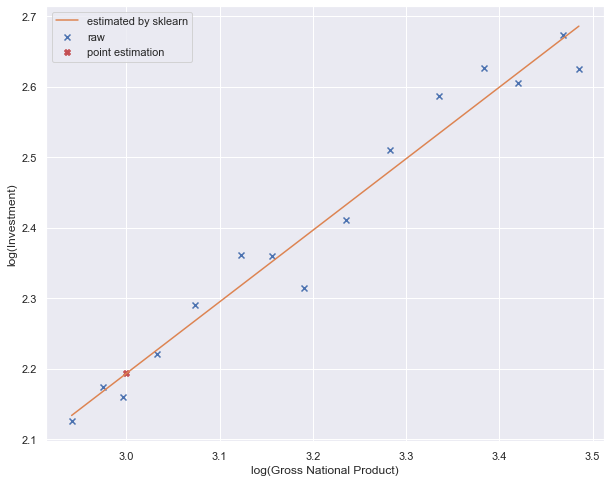

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(df["gnp"], df["invest"], label="raw", marker='x')
plt.plot(df["gnp"], sk_beta_hat0+sk_beta_hat1*df["gnp"], label="estimated by sklearn", color=colors[1])
plt.scatter(gnp, sk_invest, color=colors[3], marker="X", label="point estimation")
plt.xlabel("log(Gross National Product)")
plt.ylabel("log(Investment)")
plt.legend()
plt.show()

## Question 10

In [39]:
# design matrix
X = np.stack((np.full((n,), 1.), df["gnp"], df["interest"]), axis=1)
X

array([[ 1.        ,  2.94121319,  5.16      ],
       [ 1.        ,  2.97497199,  5.87      ],
       [ 1.        ,  2.99681802,  5.95      ],
       [ 1.        ,  3.03245758,  4.88      ],
       [ 1.        ,  3.07404807,  4.5       ],
       [ 1.        ,  3.12267451,  6.44      ],
       [ 1.        ,  3.15660972,  7.83      ],
       [ 1.        ,  3.19010749,  6.25      ],
       [ 1.        ,  3.23502316,  5.5       ],
       [ 1.        ,  3.28291653,  5.46      ],
       [ 1.        ,  3.33523719,  7.46      ],
       [ 1.        ,  3.38342037, 10.28      ],
       [ 1.        ,  3.42046735, 11.77      ],
       [ 1.        ,  3.46800744, 13.42      ],
       [ 1.        ,  3.48536647, 11.02      ]])

In [40]:
# Gram matrix
def gram(X):
    return X.T @ X
G = gram(X)

In [41]:
np.linalg.inv(G)

array([[ 5.35582897e+01, -1.89002511e+01,  9.54604525e-01],
       [-1.89002511e+01,  6.74126403e+00, -3.64492161e-01],
       [ 9.54604525e-01, -3.64492161e-01,  2.87392805e-02]])

In [42]:
eigenvalues, eigenvectors = np.linalg.eig(G)
print(f"eigenvalues: {eigenvalues}")

eigenvalues: [1.10005323e+03 1.65966072e-02 1.34943258e+01]


In [43]:
print(f"the rank of the Gram matrix is {np.linalg.matrix_rank(G)}")

the rank of the Gram matrix is 3


The Gram matrix is full-rank, indeed all its eigenvalues are positive. Thus it is invertible and the OLS solution is unique.

## Question 10

In [44]:
def OLS(X, y):
    return np.linalg.inv(gram(X)) @ X.T @ y

In [45]:
y = df["invest"]
theta_hat = OLS(X, y)
print(f"the regression coefficients (resp. intercept, relative to gnp, relative to interest) are {theta_hat}")

the regression coefficients (resp. intercept, relative to gnp, relative to interest) are [-0.94695946  1.05124269 -0.00283546]


In [46]:
def theta_variances(X, y):
    n, p = X.shape
    theta_hat = OLS(X, y)
    sigma_hat_squared = np.linalg.norm(y - X @ theta_hat, 2) / (n-p-1)
    return np.diagonal(sigma_hat_squared * np.linalg.inv(gram(X)))

In [47]:
theta_vars = theta_variances(X, y)
theta_vars

array([6.63002852e-01, 8.34507097e-02, 3.55766121e-04])

We have: $\quad \mathbb{V}(\hat{\beta_0}) \approx 0.663, \quad \mathbb{V}(\hat{\beta_1}) \approx 0.0835, \quad \mathbb{V}(\hat{\beta_2}) \approx 0.000356$

In [48]:
def r2(X, y):
    theta_hat = OLS(X, y)
    return np.corrcoef(y, X @ theta_hat)[0][1]**2 # select a non-diagonal coeff in the symmetric 2x2 matrix

In [49]:
print(f"determination coefficient = {r2(X, y):.5g}")

determination coefficient = 0.96331


In [790]:
def student_test(X, y, alpha):
    n, p = X.shape
    statistics = OLS(X, y) / np.sqrt(theta_variances(X, y))
    quantile = scipy.stats.t.ppf(1-alpha/2, n-p-1)
    return (statistics > -quantile) & (statistics < quantile)

In [791]:
alpha = 0.01
student_test(X, y, alpha)

array([ True, False,  True])

We can accept the null hypothesis at level 99% for the intercept and the coefficient relative to the explanatory variable "Interest". That is to say, these regression coefficients are not really significant and could be considered null to explain the model.

In [792]:
def p_values(X, y):
    n, p = X.shape
    return scipy.stats.t.sf(np.abs(OLS(X, y) / np.sqrt(theta_variances(X, y))), n-p-1)

In [793]:
print(f"the p-values (resp. relative to intercept, gnp, interest) are {p_values(X, y)}")

the p-values (resp. relative to intercept, gnp, interest) are [0.13472236 0.00194727 0.44161337]


We check that the p-values relative to the intercept and the "Interest" variables are high.

## Question 11

In [794]:
gnp = np.log10(1000)
interest = 10
pt_to_estimate = np.array([1, gnp, interest])
invest = np.dot(pt_to_estimate, OLS(X, y))
print(f"estimated investment = {10**invest:.5g}")

estimated investment = 150.8


This is approximately 3% lower than the previous estimation.

In [795]:
def CI(X, y, x, alpha):
    n, p = X.shape
    theta_hat = OLS(X, y)
    sigma_hat_squared = np.linalg.norm(y - X @ theta_hat, 2) / (n-p-1)
    mid = np.dot(theta_hat, x)
    halfwidth = scipy.stats.t.ppf(1-alpha/2, n-p-1) * np.sqrt(sigma_hat_squared * x.T @ np.linalg.inv(gram(X)) @ x)
    return (mid-halfwidth, mid+halfwidth)

In [796]:
def PI(X, y, x, alpha):
    n, p = X.shape
    theta_hat = OLS(X, y)
    sigma_hat_squared = np.linalg.norm(y - X @ theta_hat, 2) / (n-p-1)
    mid = np.dot(theta_hat, x)
    halfwidth = scipy.stats.t.ppf(1-alpha/2, n-p-1) * np.sqrt(sigma_hat_squared * (1 + x.T @ np.linalg.inv(gram(X)) @ x))
    return (mid-halfwidth, mid+halfwidth)

In [797]:
alpha = 0.001
CIl, CIr = CI(X, y, pt_to_estimate, alpha)
PIl, PIr = PI(X, y, pt_to_estimate, alpha)

In [798]:
print(f"For a GNP of {10**gnp} and an interest of {interest}, necessary investment at the level {100*(1-alpha)}%:\nCI = [{10**CIl:.4g}, {10**CIr:.4g}]\nPI = [{10**PIl:.4g}, {10**PIr:.4g}]")

For a GNP of 1000.0 and an interest of 10, necessary investment at the level 99.9%:
CI = [50.55, 449.9]
PI = [31.16, 729.9]


## Question 12

In [799]:
alpha = 0.001
upbounds = np.empty((n, n))
downbounds = np.empty((n, n))
for i in range(n):
    for j in range(n):
        pt = np.array([1, pltX[i][j], pltY[i][j]])
        downbounds[i][j], upbounds[i][j] = CI(X, y, pt, alpha)

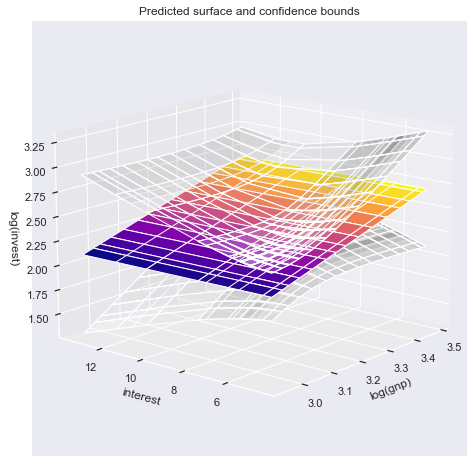

In [800]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
theta_hat = OLS(X, y)
pltX, pltY = np.meshgrid(X[:,1], X[:,2])
pltZ = theta_hat[0] + theta_hat[1]*pltX + theta_hat[2]*pltY
ax.plot_surface(pltX, pltY, pltZ, cmap="plasma")
ax.plot_surface(pltX, pltY, upbounds, cmap="Greys", alpha=.1)
ax.plot_surface(pltX, pltY, downbounds, cmap="Greys", alpha=.1)
ax.set_xlabel("log(gnp)")
ax.set_ylabel("interest")
ax.set_zlabel("log(invest)")
plt.title("Predicted surface and confidence bounds")
ax.view_init(15, -140)
plt.show()

In [801]:
%matplotlib qt
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(pltX, pltY, pltZ, cmap="plasma")
ax.plot_surface(pltX, pltY, upbounds, cmap="Greys", alpha=.1)
ax.plot_surface(pltX, pltY, downbounds, cmap="Greys", alpha=.1)
ax.set_xlabel("log(gnp)")
ax.set_ylabel("interest")
ax.set_zlabel("log(invest)")
plt.title("Predicted surface and confidence bounds")
for angle in range(-140, 220, 5):
    ax.view_init(20, angle)
    plt.draw()
    plt.pause(.1)
plt.show()

In [802]:
def update(i):
    ax.view_init(20, i)
    return ax

anim = FuncAnimation(fig, update, frames=np.arange(-140, 220, 5), interval=100)
anim.save("surface.gif")

## Question 13

In [806]:
model = LinearRegression()
model.fit(np.stack((df["gnp"], df["interest"]), axis=1), df["invest"])
print(f"sk intercept = {model.intercept_:.5g}\nsk gnp coeff = {model.coef_[0]:.5g}\nsk interest coeff = {model.coef_[1]:.5g}")

sk intercept = -0.94696
sk gnp coeff = 1.0512
sk interest coeff = -0.0028355


In [804]:
sk_rsquared = r2_score(y, X @ OLS(X, y))
print(f"determination coefficient = {sk_rsquared}")

determination coefficient = 0.9633108306726242


In [805]:
sk_invest = model.predict(np.array([gnp, interest]).reshape(1, -1))[0]
print(f"sk invest = {10**sk_invest:.5g}")

sk invest = 150.8


Once again, the values computed manually coincide with the ones using the implementations in the `scikit-learn` library.